# Loading Libraries

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import train_test_split
import pandas as pd
import scipy.stats as stats
import math

#for data visualization
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import copy
import sys
# set_matplotlib_formats('svg')

# Using GPU

In [3]:
#GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Checking waveforms

In [4]:
un_normalized_data = np.load('data/wavenumbers.npy')      #(1000)       #y()
X_ref = np.load('data/X_reference.npy')      #(60000,1000) #y(60000)
orig_data = un_normalized_data.mean() + X_ref*un_normalized_data.std()

max = 0
min = 100000
for data in orig_data:
    if np.max(data) > max:
        max = np.max(data)
    elif np.min(data) < min:
        min = np.min(data)
print(f'data max = {max}')
print(f'data min = {min}')
print(f'length = {len(orig_data)}')

print(f'data before norm max = {np.max(un_normalized_data)}')
print(f'data before norm min = {np.min(un_normalized_data)}')


data max = 1517.514882774068
data min = 1110.19469
length = 60000
data before norm max = 1792.4
data before norm min = 381.98


# Loading Reference & Test Data

In [5]:
# Train: Load input features Train Data
X_ref = np.load('data/X_reference.npy')      #(60000,1000) #y(60000)
train_waveforms = X_ref.reshape(X_ref.shape[0], 1, X_ref.shape[1])

# Train: Load output target labels Train Data
train_labels = np.load('data/y_reference.npy')      #(60000,1000) #y(60000)

# Test: Load Test Data
test_waveforms = np.load('data/X_test.npy')           #(3000, 1000) #y(3000)
test_waveforms = test_waveforms.reshape(test_waveforms.shape[0], 1, test_waveforms.shape[1])

# Test: Load output target labels Test Data
test_labels = np.load('data/y_test.npy')           #(3000, 1000) #y(3000)

In [6]:
# Check number of output target labels

print(f'train labels [{np.min(train_labels):0.0f},{np.max(train_labels):0.0f}]')
print(f'test  labels [{np.min(test_labels):0.0f},{np.max(test_labels):0.0f}]')

train labels [0,29]
test  labels [0,29]


# Convert Train & Test into tensors, Datasets & DataLoader

In [7]:
# Convert Train & Test Into Tensor

train_waveforms = torch.tensor(train_waveforms).float()
test_waveforms  = torch.tensor(test_waveforms).float()
train_labels    = torch.tensor(train_labels).long()
test_labels     = torch.tensor(test_labels).long()

In [8]:
# check if sizes are correct

print(f'#### train data ####\
    \ntrain_waveforms = {train_waveforms.shape} \
    \ntrain_labels = {train_labels.shape}\
    \n#### test data #### \
    \ntest_waveforms = {test_waveforms.shape} \
    \ntest_labels = {test_labels.shape}\
    ')

#### train data ####    
train_waveforms = torch.Size([60000, 1, 1000])     
train_labels = torch.Size([60000])    
#### test data ####     
test_waveforms = torch.Size([3000, 1, 1000])     
test_labels = torch.Size([3000])    


In [9]:
# Convert into Dataset

train_dataset = TensorDataset(train_waveforms, train_labels)
test_dataset  = TensorDataset(test_waveforms, test_labels)

In [10]:
# Split the Train dataset into Train dataset & Validation dataset

randidx         = np.random.permutation(60000)
dev_indices     = randidx[:6000]
train_indices   = randidx[6000:]
dev_dataset     = Subset(train_dataset, dev_indices)
train_dataset   = Subset(train_dataset, train_indices)

In [11]:
# Translate into dataloader objects

batchsize       = 64
train_loader    = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
dev_loader      = DataLoader(dev_dataset,   batch_size=batchsize, shuffle=True, drop_last=True)
test_loader     = DataLoader(test_dataset,  batch_size=batchsize, shuffle=True)

In [12]:
test_dataset.tensors[0].shape[2]

1000

In [13]:
X, y = next(iter(train_loader))
print(X.data.shape)

torch.Size([64, 1, 1000])


In [14]:
X, y = next(iter(dev_loader))
print(X.data.shape)

torch.Size([64, 1, 1000])


In [15]:
X, y = next(iter(test_loader))
print(X.data.shape)

torch.Size([64, 1, 1000])


# CNN Function

In [16]:
# Create the Deep Learning Model
def createTheNet(printtoggle=False):
    class cnnClassNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.print = printtoggle
            
            inChans  = 1 # RGB
            outChans = 64 # feature maps # of kernels
            krnSize  = 5 # odd number
            padding  = 2 # square if single input
            stride   = 3 # use maxpool instead of stride ... so stride = 1
            
            # First Convolution Layer
            #Conv2d(in_channels # of channels,
            #       out_channels # feature maps kernels, 
            #       kernel_size, 
            #       stride,
            #       padding  )
            self.conv1  = nn.Conv1d(inChans,outChans,krnSize, stride, padding)
            self.bnorm1 = nn.BatchNorm1d(outChans) # 64
            # output size = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
            # output size = floor( (1000 + 2*1 - 3) / 1 ) + 1 = 334
            
            padding  = 0 # square if single input

            # Second Convolution Layer
            self.conv2  = nn.Conv1d(outChans,outChans*2,krnSize, stride, padding)
            self.bnorm2 = nn.BatchNorm1d(outChans*2) # 128
            # output size = floor( (334 + 2*0 - 3) / 1 ) + 1 = 110

            # Third Convolution Layer
            self.conv3  = nn.Conv1d(outChans*2,outChans*4,krnSize, stride, padding)
            self.bnorm3 = nn.BatchNorm1d(outChans*4) # 256
        #     # output size = floor( (110 + 2*0 - 5) / 3 ) + 1 = 36

            ### ------- Linear Layer ------- ###
            self.flat_features = self.get_flat_features(train_waveforms.shape[2])

            # train_dataset.tensors[0].shape[2], size of the input waveform .. not dataset size
            
            # print(f'flatenned = {self.flat_features}')
            self.fc1 = nn.Linear(self.flat_features,512) #1024, 256
            self.fc2 = nn.Linear(512,30)

        def get_flat_features(self, imgSize):
            # Helper function to calculate the size of the flattened output
            x = torch.randn(1, 1, imgSize)
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
            return x.numel()

        def forward(self, x):
            
            if self.print: print(f'Input: {list(x.shape)}')
            
            #first conv -> maxpool -> batchnorm -> relu
            #CPBR block
            x = ( self.conv1(x) )
            if self.print: print(f'First conv: {list(x.shape)}')
            x = F.relu( self.bnorm1(x)  )
            
            x = ( self.conv2(x) )
            if self.print: print(f'Second conv: {list(x.shape)}')
            x = F.relu( self.bnorm2(x)  )

            x = ( self.conv3(x) )
            if self.print: print(f'Third conv: {list(x.shape)}')
            x = F.relu( self.bnorm3(x)  )

            #reshape for linear layer
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f'Vectorized: {list(x.shape)}')
            
            # Linear layers
            x = F.relu( self.fc1(x)   )
            x = F.dropout(x, p=0.5, training=self.training)
            if self.print: print(f'fc1: {list(x.shape)}')
                        
            x = self.fc2(x)
            if self.print: print(f'Final Output: {list(x.shape)}')
            
            
            return x
        
    modelInstance = cnnClassNet().to(device)
    
    lossfun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(modelInstance.parameters(), lr=0.001, weight_decay=1e-5)
                                #,betas=(0.5, 0.999), eps=1e-8)
    #, betas=(0.9, 0.999), eps=1e-8)
    
    return modelInstance, lossfun, optimizer

# Testing CNN with random data

In [17]:
#Test with 1 batch
net2, lossfun2, optimizer2 = createTheNet(True)

# X, y = next(iter(train_loader))
for X, y in train_loader:

    X = X.to(device)
    y = y.to(device)

    print(y)
    print("y shape", y.shape)

    yHat = net2(X)
    print(yHat)
    print("yHat shape", yHat.shape)

    #compute the loss
    loss = lossfun2(yHat, y)
    print(loss)
    
    break

c:\Users\elmog\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([27, 29, 25, 27, 12, 18, 19, 11,  0, 13, 12,  1,  1,  2,  3, 21, 19,  0,
        23, 14,  2, 21, 26, 15,  3,  3,  4, 18, 23, 27, 10, 15,  7,  8, 20, 22,
        21, 20, 12, 15,  8, 10,  4,  1, 14, 25, 17,  7, 13, 23, 28, 16, 12, 25,
        14, 21, 21,  6,  0,  2, 16,  8, 16, 15], device='cuda:0')
y shape torch.Size([64])
Input: [64, 1, 1000]
First conv: [64, 64, 334]
Second conv: [64, 128, 110]
Third conv: [64, 256, 36]
Vectorized: [64, 9216]
fc1: [64, 512]
Final Output: [64, 30]
tensor([[-0.0486, -1.0564, -0.0195,  ...,  0.4049, -0.2404,  0.2549],
        [ 0.2325, -0.3506, -0.0416,  ..., -0.2426,  0.2724,  0.4655],
        [ 0.2459, -0.2257, -0.2067,  ...,  0.1465, -0.0331, -0.0737],
        ...,
        [ 0.2013, -0.7256,  0.1010,  ...,  0.2386, -0.0230,  0.2260],
        [ 0.1126, -0.6003,  0.0475,  ..., -0.0968, -0.0552, -0.0438],
        [ 0.4612, -0.4385, -0.0279,  ...,  0.2434,  0.0925, -0.1953]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
yHat shape torch.Size([

# Training Function

In [18]:
# Train the Model

def trainTheModel(trainedModel, lossfun, optimizer, epochs=10):
    
    #number of epochs to train
    numepochs = epochs
    trainedModel.train()
        
    #initialize losses & accuracy
    trainLoss   = torch.zeros(numepochs)
    trainAcc = []
    testLoss   = torch.zeros(numepochs)
    testAcc  = []
    valLoss   = torch.zeros(numepochs)
    valAcc  = []

    for epochi in range(numepochs):
        
        #batch loss & accuracy
        trainBatchLoss = []
        trainBatchAcc  = []
        
        #loop over mini-batches
        for X,y in train_loader:
            
            # push data to GPU
            X = X.to(device)
            y = y.to(device)
            
            #Forward pass & loss
            yHat = trainedModel(X)
            loss = lossfun(yHat, y)
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #loss from this batch
            trainBatchLoss.append(loss.item())
            
            #accuracy from this batch -> for BCE sigmoid
            # trainMatches = torch.sigmoid(yHat) > 0.9 ##
            # trainMatchesNumeric = trainMatches.float()
            # trainBatchAcc.append( torch.mean( (trainMatchesNumeric == y.float()).float() ).item() )

            # batchMathces = (torch.abs(yHat - y)).detach().cpu().float().numpy()
            # batchAcc.append(( batchMathces < 0.5))
            
            # accuracy from this batch for categorical data cross entropy loss
            accMatches = torch.argmax(yHat, axis=1)
            accMatchesNumeric = (accMatches == y).float()
            trainBatchAcc.append( torch.mean(accMatchesNumeric).item() )
        
        #average accuracy across mini-batches
        trainAcc.append(100 * np.mean((trainBatchAcc)))
        
        #average losses across all mini-batches
        trainLoss[epochi] = np.mean(trainBatchLoss)
        
        ################################
        # eval mode
        # do not use dropout 
        # do not use batch normalization instead use avg
        trainedModel.eval()
        ################################
        # X,y = next(iter(test_loader))

        # X = X.to(device)
        # y = y.to(device)

        # #forward pass & loss
        # with torch.no_grad():
        #     yHat = trainedModel(X)
        #     loss = lossfun(yHat, y)
            
        # testLoss = loss.item()
            
        # testAccMatches = torch.argmax(yHat, axis=1)
        # testAccMatchesNumeric = (testAccMatches == y).float()
        # testAcc = ( 100 * torch.mean(testAccMatchesNumeric) ).item()
        # print("testAcc",testAcc)
        ################################
        #batch loss & accuracy
        testBatchLoss = []
        testBatchAcc  = []

        for X, y in test_loader:
            
            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            #forward pass & loss
            with torch.no_grad():
                yHat = trainedModel(X)
                loss = lossfun(yHat, y)
            
            #batch loss    
            testBatchLoss.append(loss.item())
            
            #batch acc cross entropy
            accMatches = torch.argmax(yHat, axis=1)
            accMatchesNumeric = (accMatches == y).float()
            testBatchAcc.append( torch.mean(accMatchesNumeric).item() )

        #compute the test accuracy for categorical data
        testAcc.append(100*np.mean(testBatchAcc))
        
        testLoss[epochi] = ( np.mean(testBatchLoss) )
        
        ################################
        ################################
        ################################
        
        #batch loss & accuracy
        valBatchLoss = []
        valBatchAcc  = []

        for X, y in dev_loader:
            
            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            #forward pass & loss
            with torch.no_grad():
                yHat = trainedModel(X)
                loss = lossfun(yHat, y)
            
            #batch loss    
            valBatchLoss.append(loss.item())
            
            #batch acc cross entropy
            accMatches = torch.argmax(yHat, axis=1)
            accMatchesNumeric = (accMatches == y).float()
            valBatchAcc.append( torch.mean(accMatchesNumeric).item() )

        #compute the test accuracy for categorical data
        valAcc.append(100*np.mean(valBatchAcc))
        
        valLoss[epochi] = ( np.mean(valBatchLoss) )

        msg1 = f'Epoch = {epochi+1}/{epochs}, # '
        msg2 = f'TrainAcc = {trainAcc[-1]:0.2f}, # '
        msg3 = f'ValAcc   = {valAcc[-1]:0.2f} # '
        msg4 = f'TestAcc  = {testAcc[-1]:0.2f}'
        sys.stdout.write('\r' + msg1 + msg2 + msg3 + msg4)

    return trainAcc, trainLoss, testAcc, testLoss, valAcc, valLoss, trainedModel

# Testing Training

In [19]:
# # Test the training code that it has NO ERRORS
# epochs=1
# myModelInstance2, lossfun2, optimizer2 = createTheNet()
# # losses2, trainedModel2 = trainTheModel(myModelInstance2, lossfun, optimizer, epochs)
# # trainAcc2, losses2, trainedModel2 = trainTheModel(myModelInstance2, lossfun, optimizer, epochs)
# trainAcc2, trainLoss2, testAcc2, testLoss2, trainedModel2 = trainTheModel(myModelInstance2, lossfun2, optimizer2, epochs)

In [20]:
# X, y = next(iter(train_loader))
# X = X.to(device)
# y = y.to(device)
# yHat = trainedModel2(X)

# Actual Training

In [21]:
# Train the Model
epochs=10
myModelInstance, lossfun, optimizer = createTheNet()
trainAcc, trainLoss, testAcc, testLoss, valAcc, valLoss, trainedModel = trainTheModel(myModelInstance, lossfun, optimizer, epochs)
# trainAcc, losses, trainedModel = trainTheModel(myModelInstance, lossfun, optimizer)
# trainAcc, testAcc, losses, trainedModel = trainTheModel(myModelInstance, lossfun, optimizer)

Epoch = 10/10, # TrainAcc = 98.36, # ValAcc   = 93.28 # TestAcc  = 42.19

In [22]:
# X, y = next(iter(train_loader))
# X = X.to(device)
# y = y.to(device)
# yHat = trainedModel(X)
# print("yHat = ",yHat)
# print("y    = ",y)

In [23]:
# testAcc

# Plotting Loss & Accuracy for reference dataset

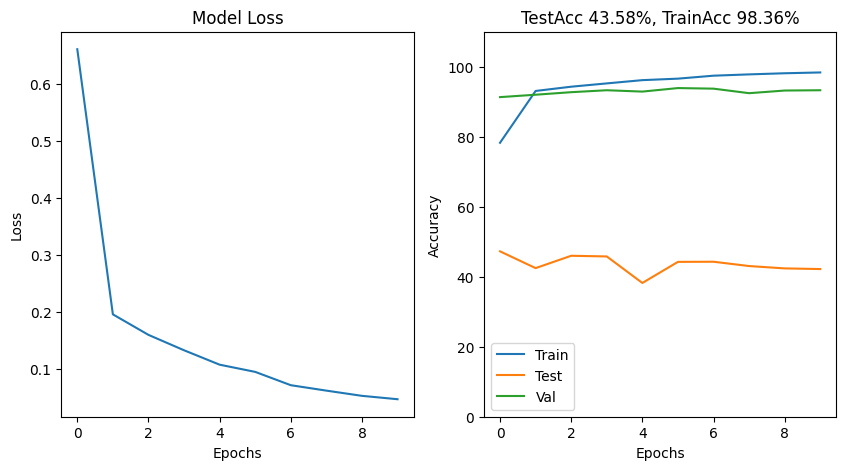

In [24]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(trainLoss, label='Train')
# ax[0].plot(testLoss, label='Dev')
# ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
# ax[0].set_xlim([0,10])

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].plot(valAcc, label='Val')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(f'TestAcc {np.mean(testAcc):.2f}%, TrainAcc {trainAcc[-1]:.2f}%')
ax[1].set_ylim([0,110])
# ax[1].set_xlim([0,5])

plt.show()

# Finetuning Training with X_Finetune

In [25]:
# fine-tuning with finetune dataset
# train_waveforms = np.load('data/X_2018clinical.npy')   #(10000,1000) #y(10000)
# train_waveforms = np.load('data/X_2019clinical.npy')   #(2500, 1000) #y(2500)
# train_labels = np.load('data/y_2018clinical.npy')   #(10000,1000) #y(10000)
# train_labels = np.load('data/y_2019clinical.npy')   #(2500, 1000) #y(2500)

X_ref = np.load('data/X_finetune.npy')       #(3000, 1000) #y(1000)
##
train_waveforms = X_ref.reshape(X_ref.shape[0], 1, X_ref.shape[1])
train_waveforms = torch.tensor(train_waveforms).float()
##
test_waveforms = np.load('data/X_test.npy')           #(3000, 1000) #y(3000)
test_waveforms = test_waveforms.reshape(test_waveforms.shape[0], 1, test_waveforms.shape[1])
test_waveforms = torch.tensor(test_waveforms).float()
##
train_labels = np.load('data/y_finetune.npy')       #(3000, 1000) #y(1000)
train_labels = torch.tensor(train_labels).long()
##
test_labels = np.load('data/y_test.npy')           #(3000, 1000) #y(3000)
test_labels = torch.tensor(test_labels).long()
##
train_dataset = TensorDataset(train_waveforms, train_labels)
test_dataset  = TensorDataset(test_waveforms, test_labels)

# Step 3: Split the testset into test & dev
randidx         = np.random.permutation(3000)
dev_indices     = randidx[:450]
train_indices   = randidx[450:]
dev_dataset     = Subset(train_dataset, dev_indices)
train_dataset   = Subset(train_dataset, train_indices)

# Step 4: Translate into dataloader objects
batchsize    = 64
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
dev_loader = DataLoader(dev_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=True)

trainAcc, trainLoss, testAcc, testLoss, valAcc, valLoss, trainedModel = trainTheModel(trainedModel, lossfun, optimizer, epochs)


Epoch = 10/10, # TrainAcc = 100.00, # ValAcc   = 93.75 # TestAcc  = 82.53

# FineTuning Bacteria Accuracy & Loss Plot

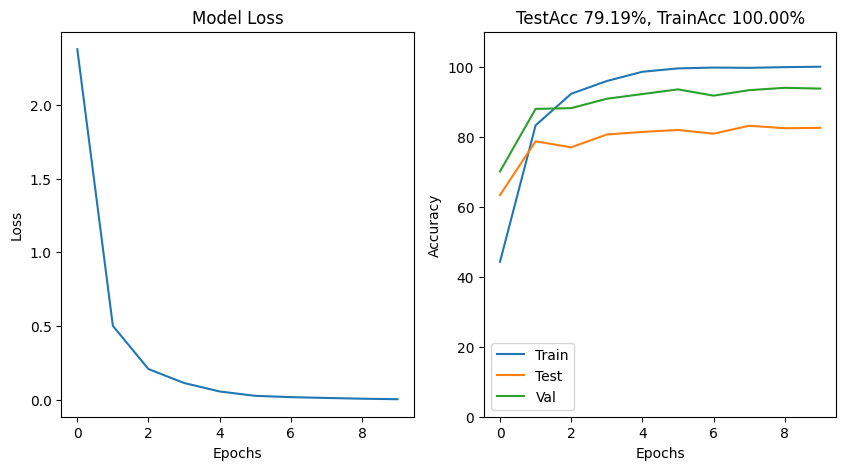

In [26]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(trainLoss, label='Train')
# ax[0].plot(testLoss, label='Dev')
# ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
# ax[0].set_xlim([0,10])

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].plot(valAcc, label='Val')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(f'TestAcc {np.mean(testAcc):.2f}%, TrainAcc {trainAcc[-1]:.2f}%')
ax[1].set_ylim([0,110])
# ax[1].set_xlim([0,5])

plt.show()

In [27]:
# bacteria_confusion = { 
#      0 :"MRSA 1 (isogenic)" #16
#     ,1 :"MRSA 2"            #17
#     ,2 :"MSSA 1"            #14
#     ,3 :"MSSA 2"            #18
#     ,4 :"MSSA 3"            #15
#     ,5 :"S. epidermidis"    #20
#     ,6 :"S. lugdunensis"    #21
#     ,7 :"S. pneumoniae 1"   #23 => order 24 in paper
#     ,8 :"S. pneumoniae 2"   #24 => order 23 in paper
#     ,9 :"Group A Strep."    #26
#     ,10:"Group B Strep."    #27
#     ,11:"Group C Strep."    #28
#     ,12:"Group G Strep."    #29
#     ,13:"S. sanguinis"      #25
#     ,14:"E. faecalis 1"     #6
#     ,15:"E. faecalis 2"     #7
#     ,16:"E. faecium"        #5
#     ,17:"E. coli 1"         #3
#     ,18:"E. coli 2"         #4
#     ,19:"K. pneumoniae 1"   #9
#     ,20:"K. pneumoniae 2"   #10
#     ,21:"K. aerogenes"      #2
#     ,22:"E. cloacae"        #8
#     ,23:"P. mirabilis"      #11
#     ,24:"S. marcescens"     #22
#     ,25:"S. enterica"       #19
#     ,26:"P. aeruginosa 1"   #12
#     ,27:"P. aeruginosa 2"   #13
#     ,28:"C. albicans"       #0
#     ,29:"C. glabrata"       #1
# }

# Lists & Dictionaries for the bacterial output labels 
# and their corresponding antibiotic

In [28]:
ORDER = [16, 17, 14, 18, 15, 20, 21, 23, 24, 26, 27, 28, 29, 25, 6, 7, 5, 3, 4,
         9, 10, 2, 8, 11, 22, 19, 12, 13, 0, 1]

# strain
bacteria_dataset = { 
     0 :"C. albicans"
    ,1 :"C. glabrata"
    ,2 :"K. aerogenes"
    ,3 :"E. coli 1"
    ,4 :"E. coli 2"
    ,5 :"E. faecium"
    ,6 :"E. faecalis 1"
    ,7 :"E. faecalis 2"
    ,8 :"E. cloacae"
    ,9:"K. pneumoniae 1"
    ,10:"K. pneumoniae 2"
    ,11:"P. mirabilis"
    ,12:"P. aeruginosa 1"
    ,13:"P. aeruginosa 2"
    ,14:"MSSA 1"
    ,15:"MSSA 3"
    ,16:"MRSA 1 (isogenic)"
    ,17:"MRSA 2"
    ,18:"MSSA 2"
    ,19:"S. enterica"
    ,20:"S. epidermidis"
    ,21:"S. lugdunensis"
    ,22:"S. marcescens"
    ,23:"S. pneumoniae 1"
    ,24:"S. pneumoniae 2"
    ,25:"S. sanguinis"
    ,26:"Group A Strep."
    ,27:"Group B Strep."
    ,28:"Group C Strep."
    ,29:"Group G Strep."
}

In [29]:


bacteria_confusion = { 
    "MRSA 1 (isogenic)"		:0 ,	#16
    "MRSA 2"            	:1 ,	#17
    "MSSA 1"            	:2 ,	#14
    "MSSA 2"            	:3 ,	#18
    "MSSA 3"            	:4 ,	#15
    "S. epidermidis"    	:5 ,	#20
    "S. lugdunensis"    	:6 ,	#21
    "S. pneumoniae 1"   	:7 ,	#23 => order 24 in paper
    "S. pneumoniae 2"   	:8 ,	#24 => order 23 in paper
    "Group A Strep."    	:9 ,	#26
    "Group B Strep."    	:10,	#27
    "Group C Strep."    	:11,	#28
    "Group G Strep."    	:12,	#29
    "S. sanguinis"      	:13,	#25
    "E. faecalis 1"     	:14,	#6
    "E. faecalis 2"     	:15,	#7
    "E. faecium"        	:16,	#5
    "E. coli 1"         	:17,	#3
    "E. coli 2"         	:18,	#4
    "K. pneumoniae 1"   	:19,	#9
    "K. pneumoniae 2"   	:20,	#10
    "K. aerogenes"      	:21,	#2
    "E. cloacae"        	:22,	#8
    "P. mirabilis"      	:23,	#11
    "S. marcescens"     	:24,	#22
    "S. enterica"       	:25,	#19
    "P. aeruginosa 1"   	:26,	#12
    "P. aeruginosa 2"   	:27,	#13
    "C. albicans"       	:28,	#0
    "C. glabrata"       	:29,	#1
}                       	   

# Confusion Matrix for Acutal Bacteria 
# vs Predicted Bacteria

y    shape = (3000,)
yHat shape = (3000,)


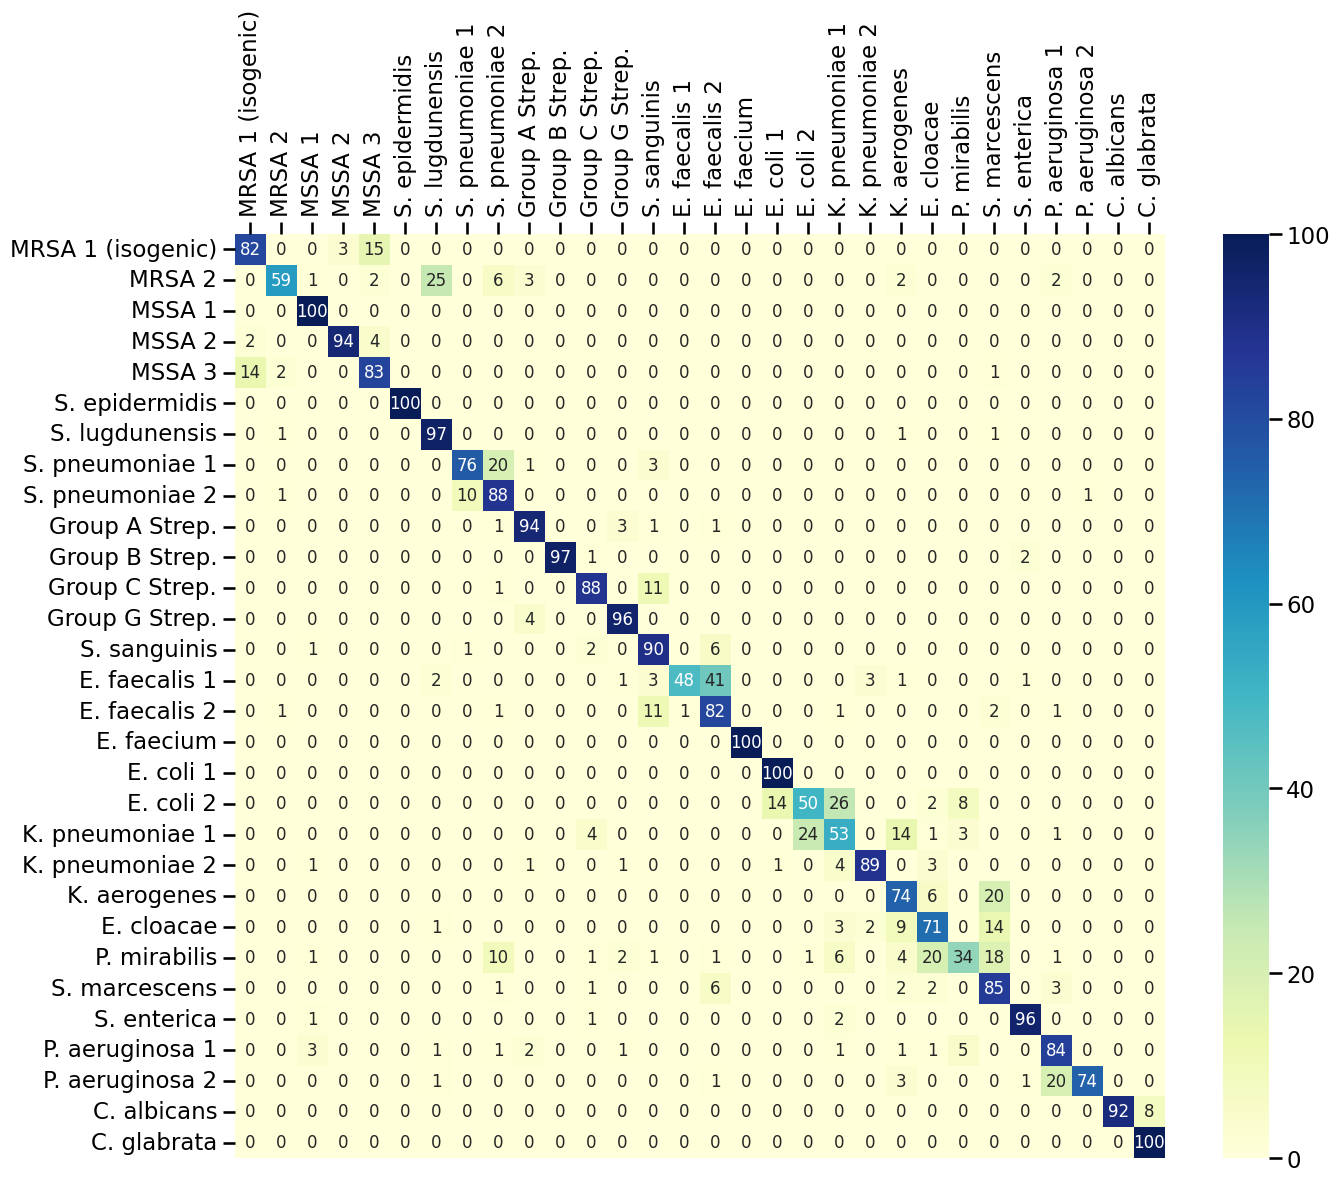

In [30]:
test_loader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=True)

for X, y in test_loader:

    X = X.to(device)
    y = y.to(device)
    trainedModel.eval()
    
    yHat = trainedModel(X)
    
y       = y.detach().cpu().numpy()
yHat    = yHat.detach().cpu().numpy()
yHat_labels = np.argmax(yHat, axis=1)
print(f'y    shape = {y.shape}')
print(f'yHat shape = {yHat_labels.shape}')

sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})

label = [bacteria_dataset[i] for i in ORDER]


cm = confusion_matrix(y, yHat_labels, labels=ORDER)
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]

plt.figure(figsize=(15, 12))
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='1.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.show()


In [31]:

ATCC_GROUPINGS = {3: 0,
                  4: 0,
                  9: 0,
                  10: 0,
                  2: 0,
                  8: 0,
                  11: 0,
                  22: 0,
                  12: 2,
                  13: 2,
                  14: 3, # MSSA
                  18: 3, # MSSA
                  15: 3, # MSSA
                  20: 3,
                  21: 3,
                  16: 3, # isogenic MRSA
                  17: 3, # MRSA
                  23: 4,
                  24: 4,
                  26: 5,
                  27: 5,
                  28: 5,
                  29: 5,
                  25: 5,
                  6: 5,
                  7: 5,
                  5: 6,
                  19: 1,
                  0: 7,
                  1: 7}

#group 3 is the 1st => Vancomycin
ab_order = [3, 4, 5, 6, 0, 1, 2, 7]

antibiotics = {}
antibiotics[0] = "Meropenem" # E. coli
antibiotics[1] = "Ciprofloxacin" # Salmonella
antibiotics[2] = "TZP" # PSA
antibiotics[3] = "Vancomycin" # Staph
antibiotics[4] = "Ceftriaxone" # Strep pneumo
antibiotics[5] = "Penicillin" # Strep + E. faecalis
antibiotics[6] = "Daptomycin" # E. faecium
antibiotics[7] = "Caspofungin" # Candidas



# Confusion matrix after conversion of predicted bacteria into Antibiotic groups

Accuracy: 96.5%


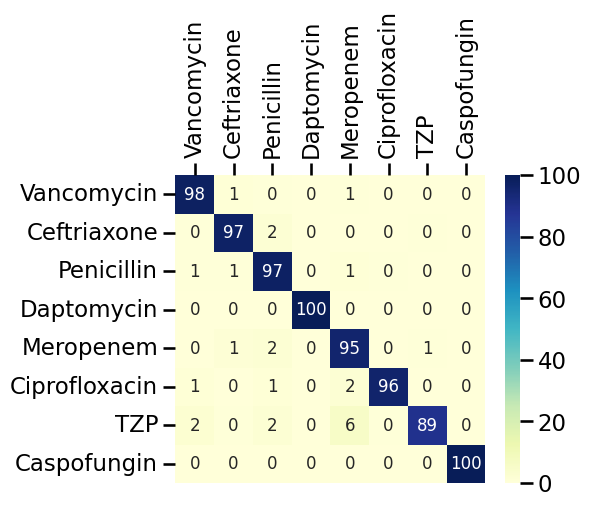

In [32]:
import time
test_loader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=True)

for X, y in test_loader:

    X = X.to(device)
    y = y.to(device)
    trainedModel.eval()
    
    yHat = trainedModel(X)
    
y       = y.detach().cpu().numpy()
yHat    = yHat.detach().cpu().numpy()
yHat_labels = np.argmax(yHat, axis=1)

# Mapping predictions into antibiotic groupings
y_ab = np.asarray([ATCC_GROUPINGS[i] for i in y])
y_ab_hat = np.asarray([ATCC_GROUPINGS[i] for i in yHat_labels])

# Computing accuracy
acc = (y_ab_hat == y_ab).mean()
print('Accuracy: {:0.1f}%'.format(100*acc))


sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})
label = [antibiotics[i] for i in ab_order]
cm = confusion_matrix(y_ab, y_ab_hat, labels=ab_order)
plt.figure(figsize=(5, 4))
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.show()

# Reserved Code
# Fine-Tuning with 2018 Clinical Data

X min =  0.0
X max =  1.0
y min =  0.0
y max =  6.0
1000
9000
y    shape = (10,)
y          = [5 3 3 0 2 5 2 6 2 6]
yHat shape = (10,)
yHat       = [19 14 16 22  2 19 19 19 12  5]


C:\Users\elmog\AppData\Local\Temp\ipykernel_11992\2070320102.py:65: RuntimeWarning: invalid value encountered in divide
  cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]


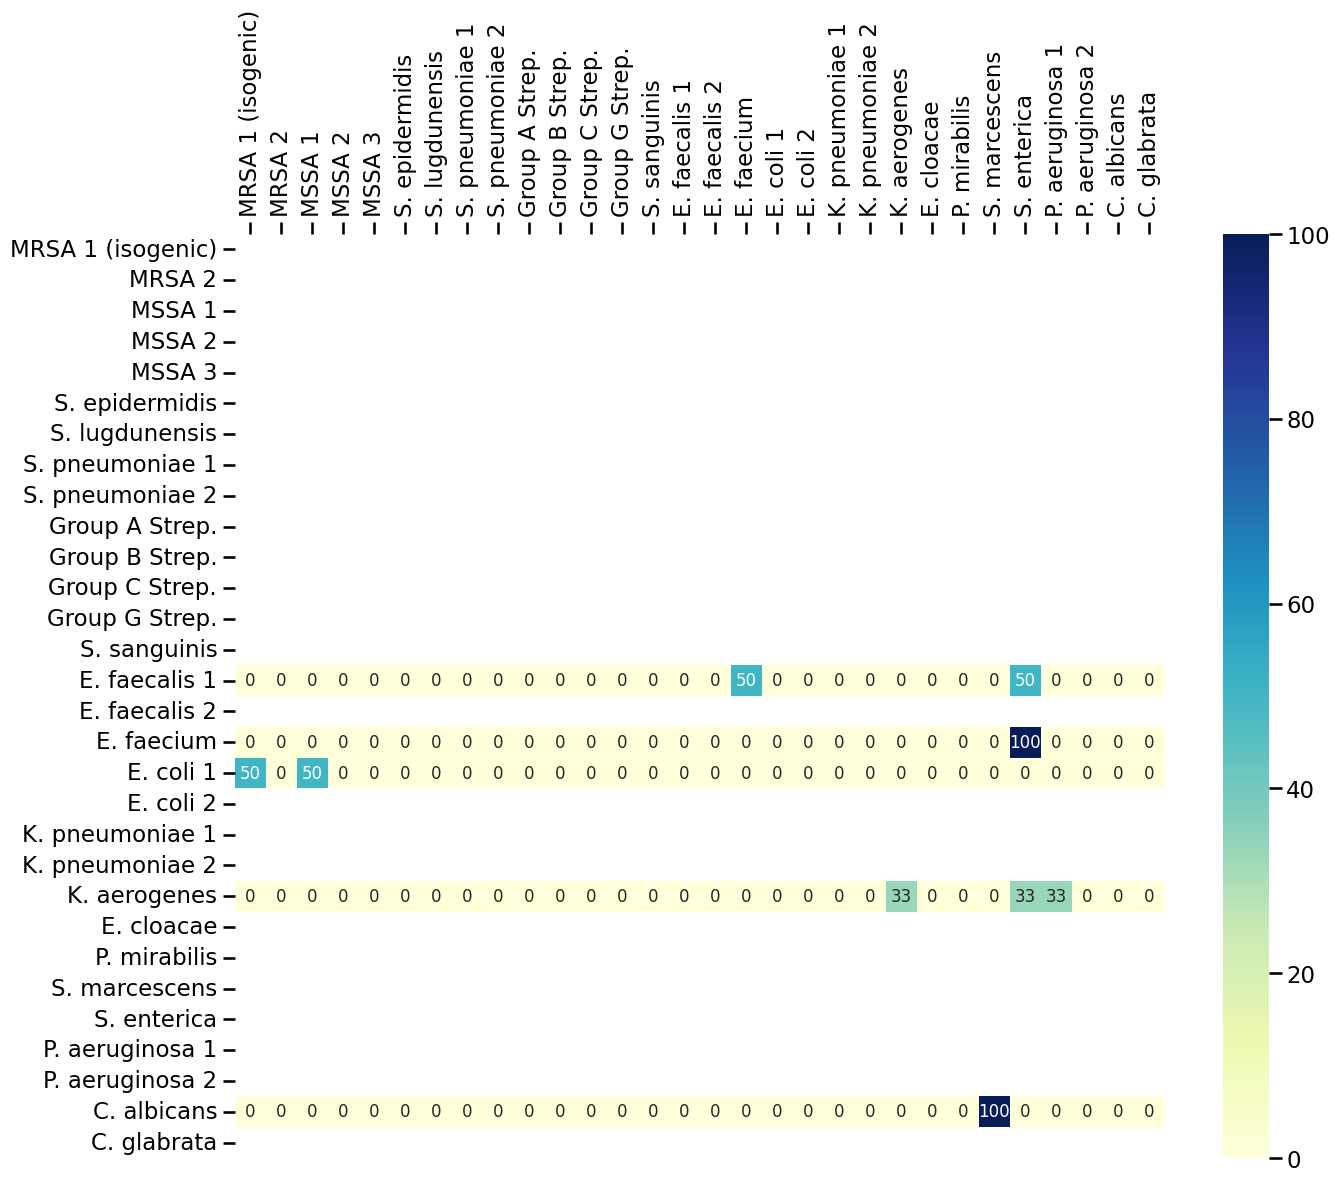

In [33]:
X_ref = np.load('data/X_2018clinical.npy')       #(10000,1000) #y(10000)
print('X min = ',np.min(X_ref))
print('X max = ',np.max(X_ref))
X_ref = np.load('data/y_2018clinical.npy')       #(10000,1000) #y(10000)
print('y min = ',np.min(X_ref))
print('y max = ',np.max(X_ref))

# fine-tuning with finetune dataset

X_ref = np.load('data/X_2018clinical.npy')       #(10000,1000) #y(10000)
##
train_waveforms = X_ref.reshape(X_ref.shape[0], 1, X_ref.shape[1])
train_waveforms = torch.tensor(train_waveforms).float()
##
test_waveforms = np.load('data/X_test.npy')           #(3000, 1000) #y(3000)
test_waveforms = test_waveforms.reshape(test_waveforms.shape[0], 1, test_waveforms.shape[1])
test_waveforms = torch.tensor(test_waveforms).float()
##
train_labels = np.load('data/y_2018clinical.npy')       #(10000,1000) #y(10000)
train_labels = torch.tensor(train_labels).long()
##
test_labels = np.load('data/y_test.npy')           #(3000, 1000) #y(3000)
test_labels = torch.tensor(test_labels).long()
##
train_dataset = TensorDataset(train_waveforms, train_labels)
test_dataset  = TensorDataset(test_waveforms, test_labels)

# Step 3: Split the testset into test & dev
randidx         = np.random.permutation(10000)
dev_indices     = randidx[:1000]
train_indices   = randidx[1000:]
dev_dataset     = Subset(train_dataset, dev_indices)
train_dataset   = Subset(train_dataset, train_indices)

print(len(dev_indices))
print(len(train_indices))
# # Step 4: Translate into dataloader objects
batchsize    = 64
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, drop_last=True)
dev_loader = DataLoader(dev_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=True)

for X, y in train_loader:

    X = X.to(device)
    y = y.to(device)
    trainedModel.eval()
    
    yHat = trainedModel(X)

y       = y.detach().cpu().numpy()
yHat    = yHat.detach().cpu().numpy()
yHat_labels = np.argmax(yHat, axis=1)
print(f'y    shape = {y.shape}')
print(f'y          = {y}')
print(f'yHat shape = {yHat_labels.shape}')
print(f'yHat       = {yHat_labels}')

sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})

label = [bacteria_dataset[i] for i in ORDER]


cm = confusion_matrix(y, yHat_labels, labels=ORDER)
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]

plt.figure(figsize=(15, 12))
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='1.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.show()

# trainAcc, trainLoss, testAcc, testLoss, valAcc, valLoss, trainedModel = trainTheModel(trainedModel, lossfun, optimizer, epochs)



Accuracy: 10.0%


C:\Users\elmog\AppData\Local\Temp\ipykernel_11992\1522928522.py:28: RuntimeWarning: invalid value encountered in divide
  cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]


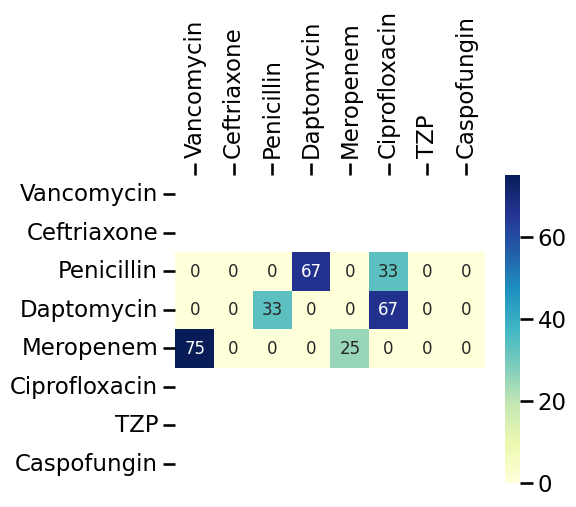

In [34]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, drop_last=True)

for X, y in train_loader:

    X = X.to(device)
    y = y.to(device)
    trainedModel.eval()
    
    yHat = trainedModel(X)
    
y       = y.detach().cpu().numpy()
yHat    = yHat.detach().cpu().numpy()
yHat_labels = np.argmax(yHat, axis=1)

# Mapping predictions into antibiotic groupings
y_ab = np.asarray([ATCC_GROUPINGS[i] for i in y])
y_ab_hat = np.asarray([ATCC_GROUPINGS[i] for i in yHat_labels])

# Computing accuracy
acc = (y_ab_hat == y_ab).mean()
print('Accuracy: {:0.1f}%'.format(100*acc))


sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})
label = [antibiotics[i] for i in ab_order]
cm = confusion_matrix(y_ab, y_ab_hat, labels=ab_order)
plt.figure(figsize=(5, 4))
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.show()